In [1]:
%pip install pyarrow

^C
Note: you may need to restart the kernel to use updated packages.


In [1]:
import polars as pl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import r2_score as r2
import joblib






color_palette = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
T640 = pl.read_csv('Data/T640.csv', 
                          schema_overrides={'NowCastConc10': pl.Float64},  # Specify correct dtype
                          ignore_errors=True,                   # Ignore parsing errors
                          null_values=["NaN"])                  # Add "NaN" to null values
MET = pl.read_csv('Data/MET.csv')

In [3]:
T640.head()


Timestamp (UTC+0),NowCast_PM10_AQI,NowCast_PM2.5_AQI,NowCastConc10,NowCastConc25,PM10,PM25
str,i64,i64,f64,f64,f64,f64
"""2024-09-27 10:00""",55,43,32.0,11.9,25.92676,10.32331
"""2024-09-27 09:00""",63,46,39.0,12.8,25.7058,11.01065
"""2024-09-27 08:00""",63,46,39.0,12.8,38.54116,12.80481
"""2024-09-27 07:00""",43,36,24.0,10.1,55.02645,15.34811
"""2024-09-27 06:00""",36,30,20.0,8.3,28.11204,12.11959


In [4]:
MET.head()
# df = pl.concat([T640, MET], rechunk=True, how='horizontal')

Timestamp (UTC+0),RH,Temp,WD,WS
str,f64,f64,f64,f64
"""2024-09-27 10:00""",85.3,29.72,256.8,0.38
"""2024-09-27 09:00""",93.7,28.2,269.0,0.401
"""2024-09-27 08:00""",100.1,26.86,278.4,0.455
"""2024-09-27 07:00""",100.6,25.33,286.9,0.539
"""2024-09-27 06:00""",100.6,25.17,285.5,0.511


In [3]:
Combined = T640.join(MET, left_on="Timestamp (UTC+0)", right_on="Timestamp (UTC+0)", how="inner")

In [5]:
Combined.head()

Timestamp (UTC+0),NowCast_PM10_AQI,NowCast_PM2.5_AQI,NowCastConc10,NowCastConc25,PM10,PM25,RH,Temp,WD,WS
str,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64
"""2024-09-27 10:00""",55,43,32.0,11.9,25.92676,10.32331,85.3,29.72,256.8,0.38
"""2024-09-27 09:00""",63,46,39.0,12.8,25.7058,11.01065,93.7,28.2,269.0,0.401
"""2024-09-27 08:00""",63,46,39.0,12.8,38.54116,12.80481,100.1,26.86,278.4,0.455
"""2024-09-27 07:00""",43,36,24.0,10.1,55.02645,15.34811,100.6,25.33,286.9,0.539
"""2024-09-27 06:00""",36,30,20.0,8.3,28.11204,12.11959,100.6,25.17,285.5,0.511


In [4]:
Combined = Combined.with_columns(
    pl.col("Timestamp (UTC+0)").str.to_datetime("%Y-%m-%d %H:%M")  # Adjust format as needed
)

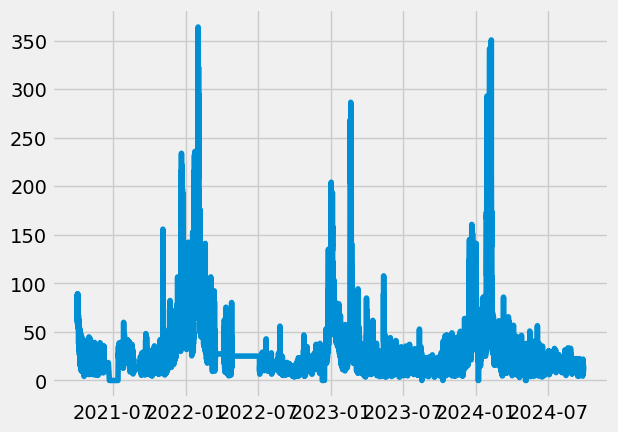

In [5]:
plt.plot(Combined['Timestamp (UTC+0)'], Combined['PM25'])

In [6]:
df = Combined.to_pandas()

In [7]:
df = df.set_index('Timestamp (UTC+0)')
df.head()

,NowCast_PM10_AQI,NowCast_PM2.5_AQI,NowCastConc10,NowCastConc25,PM10,PM25,RH,Temp,WD,WS
Timestamp (UTC+0),,,,,,,,,,
2024-09-27 10:00:00,55,43,32.0,11.9,25.92676,10.32331,85.3,29.72,256.8,0.380
2024-09-27 09:00:00,63,46,39.0,12.8,25.70580,11.01065,93.7,28.20,269.0,0.401
2024-09-27 08:00:00,63,46,39.0,12.8,38.54116,12.80481,100.1,26.86,278.4,0.455
2024-09-27 07:00:00,43,36,24.0,10.1,55.02645,15.34811,100.6,25.33,286.9,0.539
2024-09-27 06:00:00,36,30,20.0,8.3,28.11204,12.11959,100.6,25.17,285.5,0.511


In [8]:
df = df.sort_index(ascending=True)
df['pm25_lag1'] = df['PM25'].shift(1) 
total = df.iloc[(df.index <= '2023-12-31 00:00')]

In [9]:
train , test = train_test_split(total, test_size=0.25, random_state=42)
pred_test_data = df.iloc[(df.index >= '2024-01-01')& (df.index <='2024-05-31')]


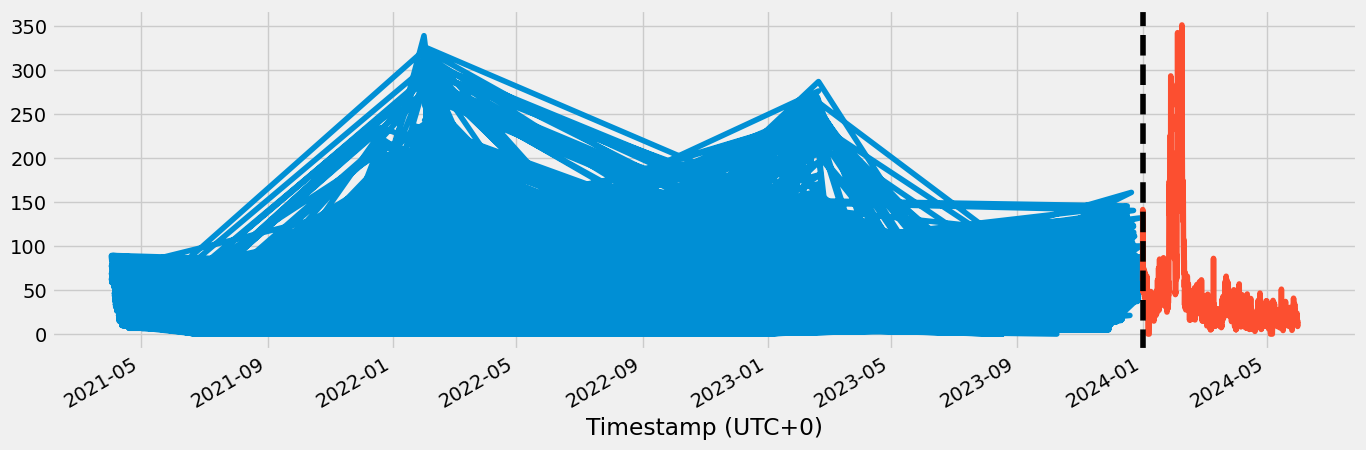

In [10]:
fig, ax = plt.subplots(figsize=(15,5))
train['PM25'].plot(ax=ax, label='Training Set')
pred_test_data['PM25'].plot(ax=ax, label='Test Set')
ax.axvline('2024-01-01', color='black', ls='--')
plt.show()

In [11]:
# Function to determine the season
def get_season(date):
    if date.month in [11, 12, 1, 2]:
        return 'Dry Season'
    elif date.month in [3,4]:
        return 'transition season'
    else:
        return 'Wet Season'

# Apply the function to create a new 'Season' column
def create_lagged_features(df):
    # Create lagged features for the previous hour
    df['RH_lag1'] = df['RH'].shift(1)
    df['Temp_lag1'] = df['Temp'].shift(1)
    df['WD_lag1'] = df['WD'].shift(1)
    df['WS_lag1'] = df['WS'].shift(1)
    df['PM10_lag1'] = df['PM10'].shift(1)
    df['PM25_lag1'] = df['PM25'].shift(1)

    
    # Drop rows with NaN values created by shifting
    df.dropna(inplace=True)
    
    return df

def create_features(df):
    df = create_lagged_features(df) 
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['Season'] = [get_season(date) for date in df.index]

    le = LabelEncoder()
    df['Season'] = le.fit_transform(df['Season'])
    df.dropna(inplace=True)
    
    return df

In [28]:
train = create_features(train)
test = create_features(test)
pred_test_data =create_features(pred_test_data)

C:\Users\Hughe\AppData\Local\Temp\ipykernel_8004\1681838777.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RH_lag1'] = df['RH'].shift(1)
C:\Users\Hughe\AppData\Local\Temp\ipykernel_8004\1681838777.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Temp_lag1'] = df['Temp'].shift(1)
C:\Users\Hughe\AppData\Local\Temp\ipykernel_8004\1681838777.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [43]:
# FEATURES = ['RH', 'Temp', 'WD', 'WS', 'hour',
#        'dayofweek', 'quarter', 'Season', 'month']
# FEATURES = ['RH', 'Temp', 'NowCast_PM2.5_AQI', 'NowCast_PM10_AQI']
# FEATURES = ['RH', 'Temp', 'hour', 'dayofweek', 'PM10', 'pm25_lag1']
FEATURES = ['RH_lag1', 'Temp_lag1', 'WS_lag1', 'PM10_lag1' ,'WD_lag1', 'hour', 'dayofweek', 'Season']
TARGET = 'PM25'

In [44]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_pred_test_data = pred_test_data[FEATURES]
y_pred_test_data = pred_test_data[TARGET]

# Stacked Model

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

# Use only the RF regressor
rf = RandomForestRegressor(n_estimators=100, ccp_alpha=0.001, max_features='sqrt', verbose=100, n_jobs=100)

base_models = [('rf', rf),('xgb',xgb.XGBRegressor(base_score=15, n_estimators=100, learning_rate=0.001))]

meta_model = LinearRegression()

reg = stacked_model = StackingRegressor(estimators=base_models, final_estimator=rf, n_jobs=50)

# Fit the model
reg.fit(X_train, y_train)

# Predict on the test set
# y_pred = model.predict(X_test)

[Parallel(n_jobs=100)]: Using backend ThreadingBackend with 100 concurrent workers.
building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100building tree 34 of 100

building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree

StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(ccp_alpha=0.001,
                                                     max_features='sqrt',
                                                     n_jobs=100, verbose=100)),
                              ('xgb',
                               XGBRegressor(base_score=15, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, ga...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                  final_estimator=RandomForestRegressor(ccp_alpha=0.001,
                                                        max_features='sqrt',
                                                        n_jobs=100,
                                                        verbose=100),
                  n_jobs=50)

In [19]:
# importance = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
# estimators = reg.named_estimators

In [20]:
# importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
# constraints

In [16]:
# test['pm25_prediction'] = reg.predict(X_test)
X_pred_test_data['pm25_prediction'] = reg.predict(X_pred_test_data)

[Parallel(n_jobs=100)]: Using backend ThreadingBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=100)]: Done   3 out of 100 | elapsed:    0.0s remaining:    1.8s
[Parallel(n_jobs=100)]: Done   5 out of 100 | elapsed:    0.0s remaining:    1.0s
[Parallel(n_jobs=100)]: Done   7 out of 100 | elapsed:    0.0s remaining:    0.7s
[Parallel(n_jobs=100)]: Done   9 out of 100 | elapsed:    0.0s remaining:    0.5s
[Parallel(n_jobs=100)]: Done  11 out of 100 | elapsed:    0.0s remaining:    0.4s
[Parallel(n_jobs=100)]: Done  13 out of 100 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=100)]: Done  15 out of 100 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=100)]: Done  17 out of 100 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=100)]: Done  19 out of 100 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=100)]: Done  21 out of 100 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=100)]: Done  23 

C:\Users\Hughe\AppData\Local\Temp\ipykernel_8004\3637825189.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pred_test_data['pm25_prediction'] = reg.predict(X_pred_test_data)


In [17]:
validate = [X_pred_test_data.sort_index().index]
validate

[DatetimeIndex(['2024-01-01 01:00:00', '2024-01-01 02:00:00',
                '2024-01-01 03:00:00', '2024-01-01 04:00:00',
                '2024-01-01 05:00:00', '2024-01-01 06:00:00',
                '2024-01-01 07:00:00', '2024-01-01 08:00:00',
                '2024-01-01 09:00:00', '2024-01-01 10:00:00',
                ...
                '2024-05-30 15:00:00', '2024-05-30 16:00:00',
                '2024-05-30 17:00:00', '2024-05-30 18:00:00',
                '2024-05-30 19:00:00', '2024-05-30 20:00:00',
                '2024-05-30 21:00:00', '2024-05-30 22:00:00',
                '2024-05-30 23:00:00', '2024-05-31 00:00:00'],
               dtype='datetime64[us]', name='Timestamp (UTC+0)', length=3484, freq=None)]

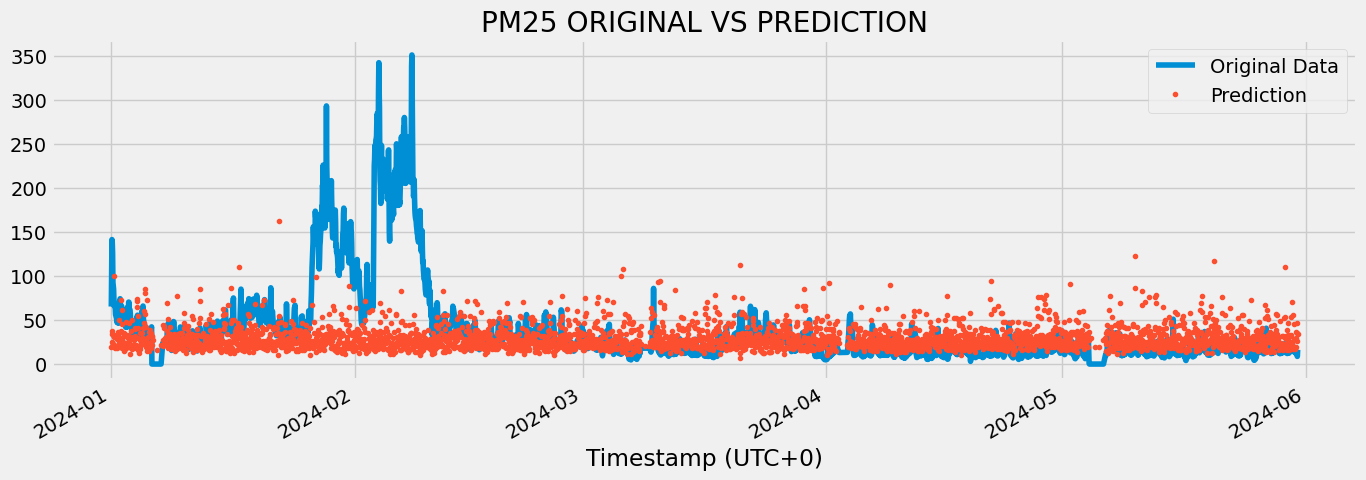

In [18]:
new_df = pred_test_data.merge(X_pred_test_data[['pm25_prediction']], how='left', left_index=True, right_index=True)
new_df = new_df[['PM25', 'pm25_prediction']]
ax = new_df[['PM25']].plot(figsize=(15,5))
new_df['pm25_prediction'].plot(ax=ax, style='.')
plt.legend(['Original Data', 'Prediction'])
ax.set_title('PM25 ORIGINAL VS PREDICTION')
plt.show()


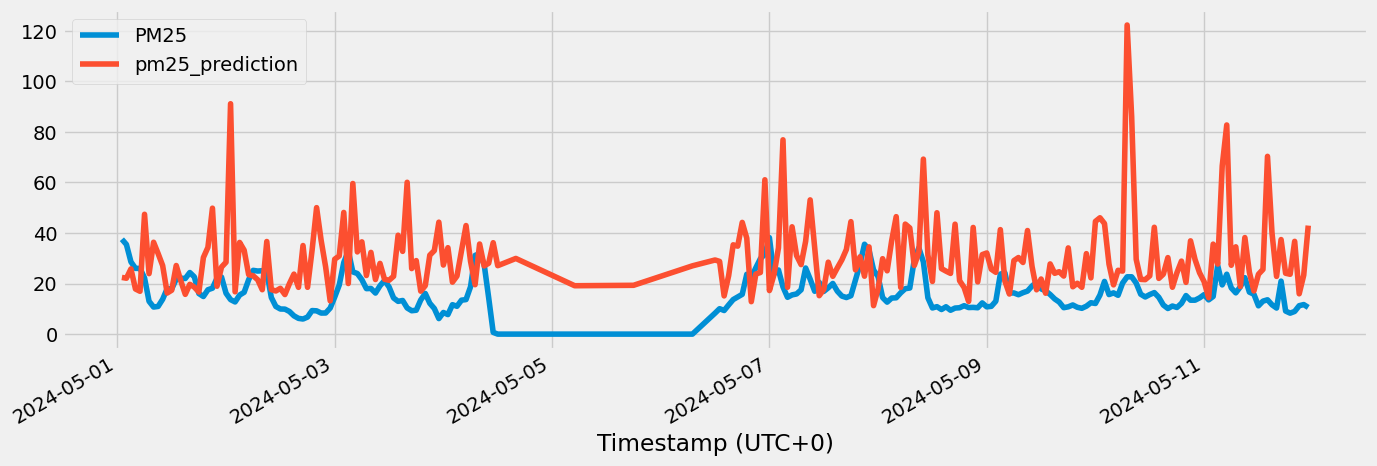

In [19]:
new_df.loc[(pred_test_data.index > '2024-05-01') & (pred_test_data.index < '2024-05-12')]\
    .plot(figsize=(15,5))
plt.show()

In [20]:
score = rmse(new_df['PM25'], new_df['pm25_prediction'])
print(f'RMSE score on test set: {score:0.2f}')


RMSE score on test set: 50.35


## Calculate Error

In [21]:
new_df['error'] = np.abs(new_df['PM25'] - new_df['pm25_prediction'])
new_df['date'] = new_df.index.date

In [22]:
new_df.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2024-02-27    6.712003
2024-02-21    7.067988
2024-03-27    7.755596
2024-01-10    8.022878
2024-02-17    8.027864
Name: error, dtype: float64

In [23]:
new_df.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2024-02-07    207.234279
2024-02-04    200.578873
2024-02-08    185.207997
2024-02-06    178.196094
2024-02-05    163.065240
Name: error, dtype: float64

In [29]:
# latest_weather = [previous_pm25_value, current_temperature, current_humidity, current_wind_speed]
# future_pm25_prediction = model.predict([latest_weather])
# print(f'Predicted PM2.5: {future_pm25_prediction[0]:.2f}')

In [25]:
r2_score = r2(new_df['PM25'], new_df['pm25_prediction'])
r2_score

-0.1186965504751738

In [34]:
joblib.dump(reg, 'aq_predict_model.joblib')

['aq_predict_model.joblib']

# GRadient Boost Regressor

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Example of hyperparameter tuning for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 1000],
    'learning_rate': [0.01, 0.1, 0.001],
    'max_depth': [3, 5, 7, 10]
}

gb_model = GradientBoostingRegressor()
grid_search = GridSearchCV(gb_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Fit the best model
best_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = best_model.predict(X_test)
score = r2(y_test, y_pred)
rmse_score = rmse(y_test, y_pred)

print(f'Best R² score: {score:.2f}')
print(f'Best RMSE score: {rmse_score:.2f}')

: 

In [ ]:
best_model

GradientBoostingRegressor(learning_rate=0.01, n_estimators=200)

# Random Forest Regressor

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse


In [32]:
rf = RandomForestRegressor(n_estimators=1000, ccp_alpha=0.001, max_features='sqrt', verbose=100, n_jobs=100)

rf.fit(X_train, y_train)

[Parallel(n_jobs=100)]: Using backend ThreadingBackend with 100 concurrent workers.
building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000building tree 37 of 1000
b

RandomForestRegressor(ccp_alpha=0.001, max_features='sqrt', n_estimators=1000,
                      n_jobs=100, verbose=100)

In [33]:
X_pred_test_data['pm25_prediction'] = rf.predict(X_pred_test_data)

[Parallel(n_jobs=100)]: Using backend ThreadingBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=100)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=100)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=100)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=100)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=100)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=100)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=100)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=100)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=100)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=100)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=100)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=100)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=100)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=100)]: Done  15 t

C:\Users\Hughe\AppData\Local\Temp\ipykernel_8004\3399381969.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pred_test_data['pm25_prediction'] = rf.predict(X_pred_test_data)


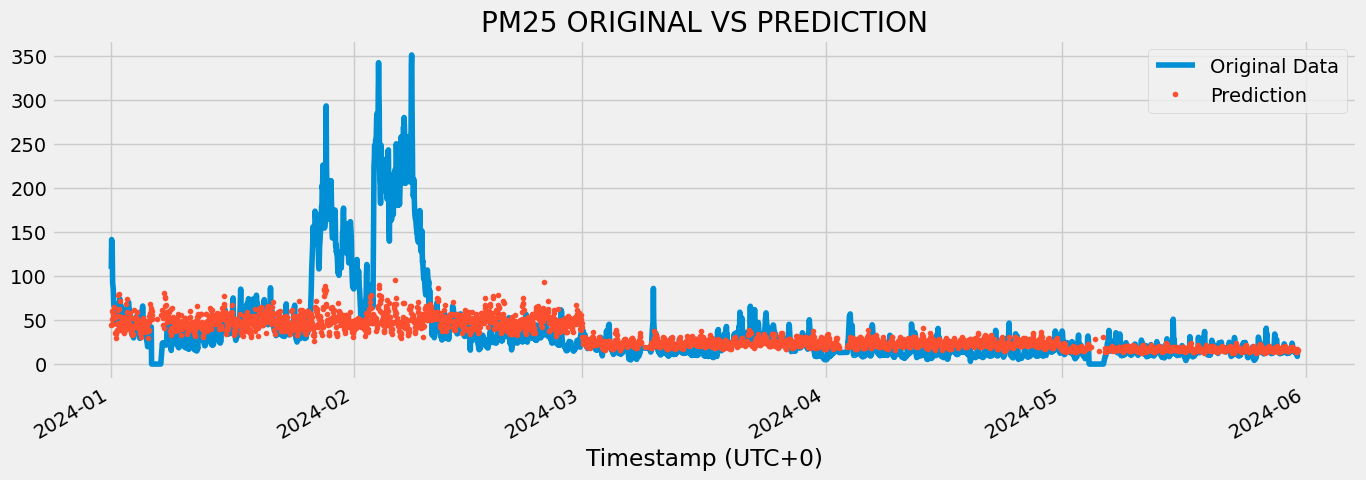

In [34]:
new_rf_df = pred_test_data.merge(X_pred_test_data[['pm25_prediction']], how='left', left_index=True, right_index=True)
new_rf_df = new_rf_df[['PM25', 'pm25_prediction']]
ax = new_rf_df[['PM25']].plot(figsize=(15,5))
new_rf_df['pm25_prediction'].plot(ax=ax, style='.')
plt.legend(['Original Data', 'Prediction'])
ax.set_title('PM25 ORIGINAL VS PREDICTION')
plt.show()

In [35]:
r2_score = r2(new_rf_df['PM25'], new_rf_df['pm25_prediction'])
r2_score

0.22162146157756857

In [36]:
score = rmse(new_rf_df['PM25'], new_rf_df['pm25_prediction'])
print(f'RMSE score on test set: {score:0.2f}')

RMSE score on test set: 42.00


In [39]:
score = mae(new_rf_df['PM25'], new_rf_df['pm25_prediction'])
print(f'MAE score on test set: {score:0.2f}')

MAE score on test set: 20.82


In [40]:
score = mse(new_rf_df['PM25'], new_rf_df['pm25_prediction'])
print(f'MSE score on test set: {score:0.2f}')

MSE score on test set: 1764.15


In [ ]:
joblib.dump(rf, 'regression_model.joblib')

['regression_model.joblib']